In [1]:
import copy
import time, importlib
import h5py
import numpy as np
import os
import pandas as pd
import scipy, scipy.ndimage
import tqdm
import unyt

In [2]:
import kalepy as kale

In [3]:
import matplotlib
import matplotlib.colors
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as patheffects

In [4]:
import palettable

In [5]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.config as l_config

In [6]:
import galaxy_dive.plot_data.plotting as plotting

In [7]:
import coolingFunction

In [8]:
import trove
import verdict
from py2tex import py2tex

In [9]:
import helpers

In [10]:
%matplotlib inline
matplotlib.style.use( '~/repos/clean-bold/clean-bold.mplstyle' )

# Parameters

## Manual

In [11]:
pm = dict(
    snum = 600,
    ahf_index = 600,
    variation = 'm12i_md',
    global_variation = 'relative_to_accretion',
)

In [12]:
global_variations = [
    '',
#     'track_all_thin_disk_stars',
#     'track_all_recent_stars',
]

In [13]:
labels = [
    'main sample',
#     r'all stars with $j_z/j_c(E) > 0.8$',
    r'all stars with age $<1$ Gyr',
    r'all stars with $j_z/j_c(E) > 0.9$',
]

In [14]:
cmap = palettable.cartocolors.qualitative.Pastel_10.mpl_colors
colors = [ cmap[0], cmap[1], cmap[3], cmap[5] ]

# Load Data

In [15]:
pm = trove.link_params_to_config(
    '/home1/03057/zhafen/papers/Hot-Accretion-in-FIRE/analysis/hot_accretion.trove',
    script_id = 'nb.8',
    **pm
)

In [16]:
w = a_worldlines.Worldlines(
    tag = pm['tag'],
    data_dir = pm['data_dirs']['jug.4'],
    halo_data_dir = pm['halo_data_dir'],
    ahf_index = pm['ahf_index'],
)

# Calculate Accretion and cooling time

## Times

In [17]:
tacc_inds = w.calc_tacc_inds(
    lookback_time_max = pm['lookback_time_max'],
    choose_first = pm['choose_first'],
)

100%|██████████| 45846/45846 [00:03<00:00, 12362.63it/s]


In [18]:
tcools_inds = w.calc_tcools_inds(
    lookback_time_max = pm['lookback_time_max'],
    choose_first = pm['choose_first'],
    B = pm['logTcools'],
)

100%|██████████| 45846/45846 [00:02<00:00, 18254.06it/s]


In [19]:
is_hot_accretion = w.calc_is_hot_accretion(
    lookback_time_max = pm['lookback_time_max'],
    choose_first = pm['choose_first'],
    B = pm['logTcools'],
)

100%|██████████| 45846/45846 [00:04<00:00, 11030.76it/s]
/home1/03057/zhafen/repos/galaxy-dive/galaxy_dive/analyze_data/simulation_data.py:1181: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.halo_coords = halo_coords_comoving * scale_factor_and_hinv[np.newaxis, :]
100%|██████████| 45846/45846 [00:25<00:00, 1823.42it/s]


In [20]:
is_accreted = tacc_inds != l_config.INT_FILL_VALUE
valid = is_accreted & ( tcools_inds != l_config.INT_FILL_VALUE )
tacc_inds = tacc_inds[valid]
tcools_inds = tcools_inds[valid]
particle_inds = np.arange( w.n_particles )[valid]

In [21]:
tacc = w.get_data( 'tacc' )[particle_inds]
tcools = w.get_data( 'tcools' )[particle_inds]

# What Criteria is Important?

## Identify Location in Radius-Density Space at Accretion

In [22]:
w.data_masker.clear_masks()
w.mask_data( 'PType', data_value=0 )

In [23]:
r_gal = np.full( w.n_snaps, np.nan )
r_gal[:w.r_gal.size] = w.r_gal

In [24]:
rrgal_acc = ( w.get_selected_data( 'R', compress=False ) / r_gal )[particle_inds,tacc_inds].compressed()
n_acc = w.get_selected_data( 'Den', compress=False )[particle_inds,tacc_inds].compressed()

In [25]:
is_dense = n_acc > l_config.GALAXY_DENSITY_CUT
is_near = rrgal_acc < 1
is_dense_but_far = is_dense & np.invert( is_near )
is_near_but_underdense = np.invert( is_dense ) & is_near
is_underdense_and_far = np.invert( is_dense ) & np.invert( is_near )

In [26]:
p_dense_but_far = is_dense_but_far.sum() / rrgal_acc.size * 100
p_near_but_underdense = is_near_but_underdense.sum() / rrgal_acc.size * 100
p_underdense_and_far = is_underdense_and_far.sum() / rrgal_acc.size * 100

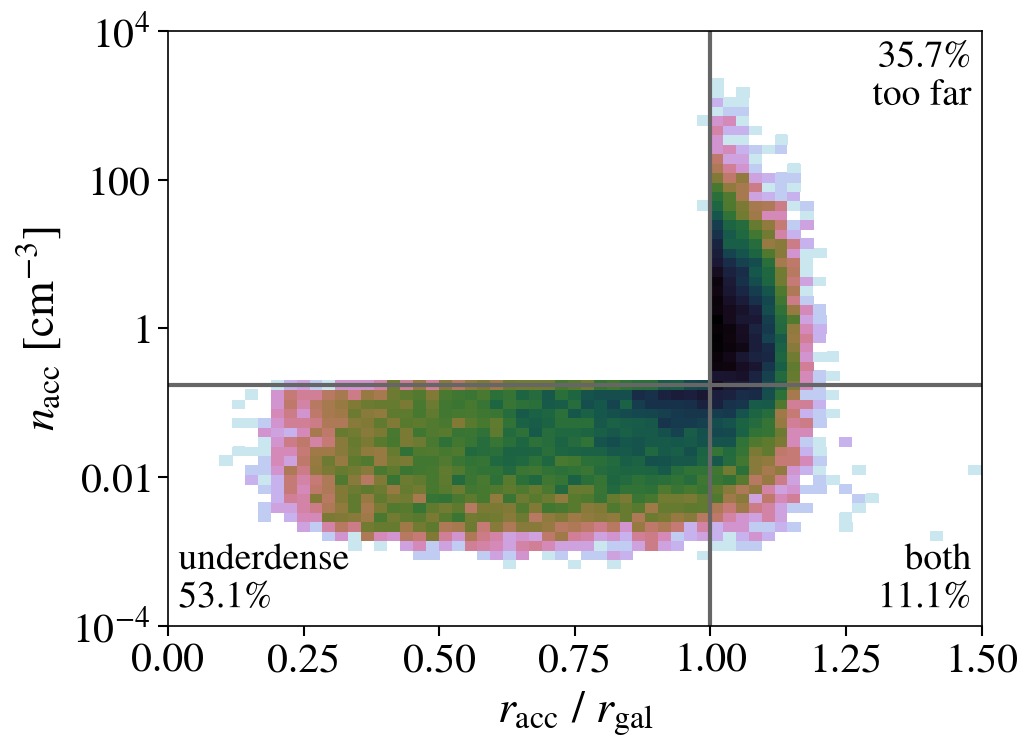

In [27]:
fig = plt.figure( facecolor='w' )
ax = plt.gca()

n_bins = 64
bins = [
    np.linspace( 0, 1.5, n_bins ),
    np.logspace( -4, 4, n_bins ),
]
hist, x_edges, y_edges, img = ax.hist2d(
    rrgal_acc,
    n_acc,
    bins = bins,
    cmap = 'cubehelix_r',
    norm = matplotlib.colors.LogNorm()
)

text = ax.annotate(
    text = '{:.3g}%\ntoo far'.format( p_dense_but_far ),
    xy = ( 1, 1 ),
    xytext = ( -5, -5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    fontsize = 18,
    ha = 'right', 
    va = 'top',
)
text.set_path_effects([
    patheffects.Stroke(linewidth=3, foreground='white'),
    patheffects.Normal()
])
text = ax.annotate(
    text = 'underdense\n{:.3g}%'.format( p_near_but_underdense ),
    xy = ( 0, 0 ),
    xytext = ( 5, 5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    fontsize = 18,
    ha = 'left', 
    va = 'bottom',
)
text.set_path_effects([
    patheffects.Stroke(linewidth=3, foreground='white'),
    patheffects.Normal()
])
text = ax.annotate(
    text = 'both\n{:.3g}%'.format( p_underdense_and_far ),
    xy = ( 1, 0 ),
    xytext = ( -5, 5 ),
    xycoords = 'axes fraction',
    textcoords = 'offset points',
    fontsize = 18,
    ha = 'right', 
    va = 'bottom',
)
text.set_path_effects([
    patheffects.Stroke(linewidth=3, foreground='white'),
    patheffects.Normal()
])

ax.axvline(
    1.,
    color = pm['background_linecolor'],
    linewidth = 2,
)
ax.axhline(
    l_config.GALAXY_DENSITY_CUT,
    color = pm['background_linecolor'],
    linewidth = 2,
)

ax.set_xlabel( r'$r_{\rm acc}$ / $r_{\rm gal}$', fontsize=22 )
ax.set_ylabel( r'$n_{\rm acc}$ [cm$^{-3}$]', fontsize=22 )
ax.set_yscale( 'log' )